In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

In [5]:
#load the dataset

df = pd.read_csv("../data/raw/bank-additional-full.csv", sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
# Handle unknown values (Flag + Replacement)

cat_cols = df.select_dtypes(include="object").columns

for col in cat_cols:
    if "unknown" in df[col].values:
        df[col+"_unknown_flag"] = (df[col]=="unknown").astype(int)
        mode_val = df[col].replace("unknown", np.nan).mode()[0]
        df[col] = df[col].replace("unknown", mode_val)

C:\Users\surjann\AppData\Local\Temp\ipykernel_20388\3292859356.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include="object").columns


In [7]:
# Encode categorical variables

le = LabelEncoder()

for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

C:\Users\surjann\AppData\Local\Temp\ipykernel_20388\3210590176.py:5: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include="object").columns:


In [8]:
# Split Features and Target

X_full = df.drop("y", axis=1)
y_full = df["y"]

In [9]:
# Remove 'duration' feature

X_full = X_full.drop(columns=["duration"], errors="ignore")

In [10]:
# set a seed for reproducibility
np.random.seed(42)

# split the data into a training and testing set. hint: use train_test_split !

X, X_test, y, y_test = train_test_split(X_full, y_full, train_size = 0.80, shuffle= True, stratify = y_full)

In [58]:
# Feature selection pipeline


# =====================================================
# FUNCTION
# =====================================================
def auto_feature_pipeline(X, y,
                          corr_threshold=0.85,
                          min_features=5,
                          cv=5):

    X = X.copy()

    print("Original shape:", X.shape)

    # -------------------------------------------------
    # 1. Remove constant columns
    # -------------------------------------------------
    nunique = X.nunique()
    constant_cols = nunique[nunique <= 1].index

    X.drop(columns=constant_cols, inplace=True)

    print("Removed constant columns:", len(constant_cols))

    # -------------------------------------------------
    # 2. Remove highly correlated features
    # -------------------------------------------------
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )

    high_corr_cols = [
        col for col in upper.columns
        if any(upper[col] > corr_threshold)
    ]

    X.drop(columns=high_corr_cols, inplace=True)

    print("Removed highly correlated columns:", len(high_corr_cols))

    # -------------------------------------------------
    # 3. Find optimal number of features
    # -------------------------------------------------
    results = []

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for k in range(min_features, X.shape[1] + 1):

        selector = SelectKBest(score_func=f_classif, k=k)
        X_selected = selector.fit_transform(X_scaled, y)

        model = LogisticRegression(max_iter=2000)

        score = cross_val_score(
            model,
            X_selected,
            y,
            cv=cv,
            scoring="roc_auc"
        ).mean()

        results.append((k, score))

    results_df = pd.DataFrame(results, columns=["k", "score"])
    best_k = results_df.loc[results_df.score.idxmax(), "k"]

    print("Best number of features:", best_k)

    # -------------------------------------------------
    # 4. Select best features
    # -------------------------------------------------
    selector = SelectKBest(score_func=f_classif, k=best_k)
    selector.fit(X_scaled, y)

    selected_features = X.columns[selector.get_support()]

    print("\nSelected Features:")
    print(list(selected_features))

    # -------------------------------------------------
    # 5. Return cleaned dataset
    # -------------------------------------------------
    return X[selected_features], selected_features, results_df


# =====================================================
# RUN PIPELINE
# =====================================================
X_selected, selected_features, scores = auto_feature_pipeline(X, y)

Original shape: (32950, 25)
Removed constant columns: 0
Removed highly correlated columns: 3
Best number of features: 19

Selected Features:
['age', 'job', 'marital', 'education', 'default', 'housing', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'marital_unknown_flag', 'education_unknown_flag', 'default_unknown_flag']


<Axes: title={'center': 'Feature Count vs Model Score'}, xlabel='k'>

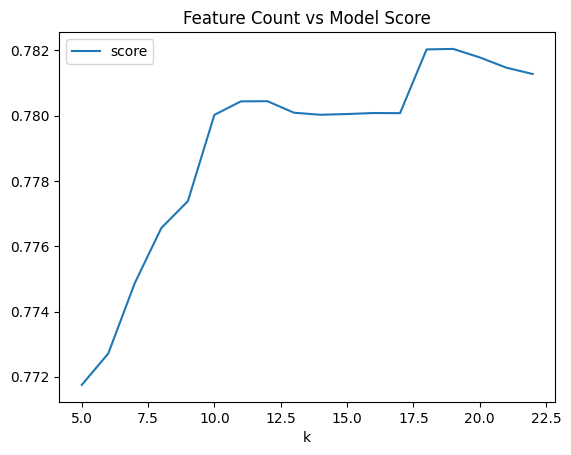

In [59]:
# Visualise the performance

scores.plot(x="k", y="score", kind="line", title="Feature Count vs Model Score")

In [11]:
# Advanced pipeline 

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# =====================================================
# FUNCTION
# =====================================================
def advanced_pipeline(X, y, corr_threshold=0.85):

    X = X.copy()
    print("Original shape:", X.shape)

    # -------------------------------------------------
    # 1. Remove constant columns
    # -------------------------------------------------
    constant_cols = X.columns[X.nunique() <= 1]
    X.drop(columns=constant_cols, inplace=True)
    print("Removed constant:", len(constant_cols))

    # -------------------------------------------------
    # 2. Remove correlated columns
    # -------------------------------------------------
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    drop_cols = [c for c in upper.columns if any(upper[c] > corr_threshold)]
    X.drop(columns=drop_cols, inplace=True)
    print("Removed correlated:", len(drop_cols))

    # -------------------------------------------------
    # 3. Dynamic k range for feature selection
    # -------------------------------------------------
    n_features = X.shape[1]
    # Build a list of k values from 1 up to n_features (step ~10% of total)
    step = max(1, n_features // 10)
    k_range = sorted(set(
        list(range(1, n_features + 1, step)) + [n_features]
    ))
    print(f"Testing k values: {k_range}  (out of {n_features} features)")

    # -------------------------------------------------
    # 4. Models + Hyperparameter grids
    # -------------------------------------------------
    models = {

        "logistic": (
            LogisticRegression(max_iter=3000),
            {
                "select__k": k_range,
                "model__C": [0.01, 0.1, 1, 10]
            }
        ),

        "random_forest": (
            RandomForestClassifier(),
            {
                "select__k": k_range,
                "model__n_estimators": [100, 200],
                "model__max_depth": [None, 5, 10]
            }
        ),

        "gradient_boost": (
            GradientBoostingClassifier(),
            {
                "select__k": k_range,
                "model__n_estimators": [100, 200],
                "model__learning_rate": [0.01, 0.1]
            }
        )
    }

    best_score = 0
    best_model = None
    best_name = None
    all_results = []

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # -------------------------------------------------
    # 5. Model Search
    # -------------------------------------------------
    for name, (model, params) in models.items():

        pipe = Pipeline([
            ("scale", StandardScaler()),
            ("select", SelectKBest(f_classif)),
            ("model", model)
        ])

        grid = GridSearchCV(
            pipe,
            params,
            cv=cv,
            scoring="roc_auc",
            n_jobs=-1
        )

        grid.fit(X, y)

        # Collect per-k scores for this model
        cv_results = pd.DataFrame(grid.cv_results_)
        k_scores = (
            cv_results
            .groupby("param_select__k")["mean_test_score"]
            .max()
            .reset_index()
            .rename(columns={"param_select__k": "k", "mean_test_score": name})
        )
        all_results.append(k_scores.set_index("k"))

        best_k_for_model = grid.best_params_.get("select__k", "all")
        print(f"{name}  |  best AUC: {grid.best_score_:.4f}  |  best k: {best_k_for_model}")

        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_model = grid.best_estimator_
            best_name = name

    # -------------------------------------------------
    # 6. Combine results for plotting
    # -------------------------------------------------
    results_df = pd.concat(all_results, axis=1).reset_index()
    results_df.columns.name = None

    # -------------------------------------------------
    # 7. Final selected features
    # -------------------------------------------------
    selector = best_model.named_steps["select"]
    selected_features = X.columns[selector.get_support()]

    print(f"\n🏆 BEST MODEL: {best_name}")
    print(f"Best AUC Score: {best_score:.4f}")
    print(f"Optimal k: {len(selected_features)}")
    print("Selected Features:", list(selected_features))

    return best_model, selected_features, results_df


# =====================================================
# RUN
# =====================================================
model, features, results_df = advanced_pipeline(X, y)

Original shape: (32950, 25)
Removed constant: 0
Removed correlated: 3
Testing k values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 22]  (out of 22 features)
logistic  |  best AUC: 0.7813  |  best k: 21
random_forest  |  best AUC: 0.7919  |  best k: 21
gradient_boost  |  best AUC: 0.7935  |  best k: 21

🏆 BEST MODEL: gradient_boost
Best AUC Score: 0.7935
Optimal k: 21
Selected Features: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'job_unknown_flag', 'marital_unknown_flag', 'education_unknown_flag', 'default_unknown_flag']


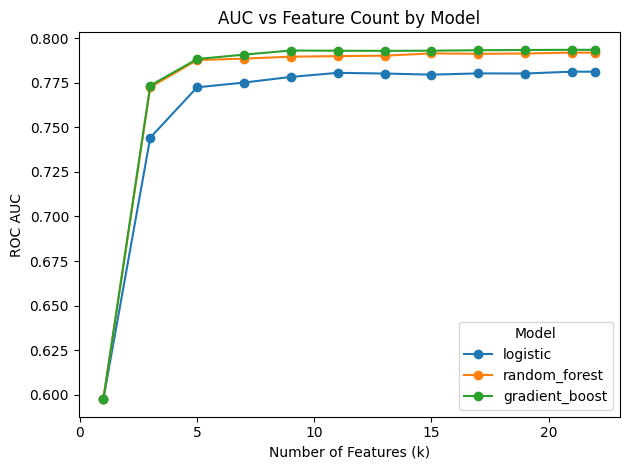

In [ ]:
# Visualise: AUC vs number of features for each model

results_df.set_index("k").plot(
    kind="line", marker="o",
    title="AUC vs Feature Count by Model",
    ylabel="ROC AUC", xlabel="Number of Features (k)"
)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [49]:
# Use best model

preds = model.predict(X[features])

In [40]:
# Probability prediction

proba = model.predict_proba(X[features])[:,1]